In [3]:
# It's assumed you have a Python environment where you can install packages. If not, you might need to set one up first.

# First, ensure you have the necessary packages installed. You can do this by running the following command in your terminal or command prompt:
# pip install tensorflow numpy matplotlib opencv-python-headless pandas scikit-learn

# Note: We use 'opencv-python-headless' instead of 'opencv-python' to avoid unnecessary GUI dependencies for server environments.

# Importing necessary libraries

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import legacy


# Helper libraries
import os
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Deploy
from keras.models import load_model
# pip install pynput
# pip install pynput opencv-python
from pynput.keyboard import Key, Controller
from threading import Thread
import asyncio
import threading

# Display TensorFlow version
print(tf.__version__)

# Note: '%matplotlib inline' is specific to Jupyter notebooks and IPython environments to display plots inline. 
# In a standard Python script, matplotlib will display plots in a separate window. 
# If you're running

# Please start with:
# Creating a virtual environment (if you haven't already)
# python -m venv venv

# Activating the virtual environment
# On Windows
# venv\Scripts\activate
# On MacOS/Linux
# source myenv/bin/activate

# Install TensorFlow within the activated virtual environment
# pip install tensorflow

2.15.0


# Uploading Data

In [2]:
# Unzip images, ignore this cell if files are already in the workspace
!unzip -o Gesture_Data_2.zip
print(os.listdir())  # This will print the contents of the current working directory

Archive:  Gesture_Data_2.zip
  inflating: __MACOSX/._Gesture_Data_2  
  inflating: __MACOSX/Gesture_Data_2/._01_Up  
  inflating: Gesture_Data_2/.DS_Store  
  inflating: __MACOSX/Gesture_Data_2/._.DS_Store  
  inflating: __MACOSX/Gesture_Data_2/._05_OpenPalm   
  inflating: __MACOSX/Gesture_Data_2/._06_Fist  
  inflating: __MACOSX/Gesture_Data_2/._03_Left  
  inflating: __MACOSX/Gesture_Data_2/._04_Right  
  inflating: __MACOSX/Gesture_Data_2/._02_Down  
  inflating: Gesture_Data_2/01_Up/04D5801C-3102-456A-9B66-12C82252B5F3.jpeg  
  inflating: __MACOSX/Gesture_Data_2/01_Up/._04D5801C-3102-456A-9B66-12C82252B5F3.jpeg  
  inflating: Gesture_Data_2/01_Up/35B7C513-51BB-411C-ABB9-3C9252630241.jpeg  
  inflating: __MACOSX/Gesture_Data_2/01_Up/._35B7C513-51BB-411C-ABB9-3C9252630241.jpeg  
  inflating: Gesture_Data_2/01_Up/7E686BD5-F588-47FA-AFC8-92E18894CC9A.jpeg  
  inflating: __MACOSX/Gesture_Data_2/01_Up/._7E686BD5-F588-47FA-AFC8-92E18894CC9A.jpeg  
  inflating: Gesture_Data_2/01_Up/Photo 

In [3]:
# Get all the paths for the images to later load them
imagepaths = []

# Go through all the JPEG files (.jpg and .jpeg) inside the current directory and its subdirectories
for filename in glob.iglob("**/*.jpg", recursive=True):
    imagepaths.append(filename)
for filename in glob.iglob("**/*.jpeg", recursive=True):
    imagepaths.append(filename)

print(len(imagepaths))  # If > 0, then a JPEG image was loaded

1200


In [4]:
# Define Advanced Preprocessing Function
def load_and_preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)  # Read the image in color mode
    img_resized = cv2.resize(img, (160, 160))  # Resize to the size expected by MobileNetV2
    img_normalized = img_resized.astype('float32') / 255  # Normalize pixel values
    # No need to convert to grayscale or stack channels since MobileNetV2 expects color images
    return img_normalized

In [5]:
# Load Images and Labels with Advanced Preprocessing
X = []  # Image data
y = []  # Labels
for path in imagepaths:
    X.append(load_and_preprocess_image(path))
    
    # Extracting label from the path
    category = path.split("/")[1]  # Adjust based on your directory structure
    label = int(category.split("_")[0])
    y.append(label)

In [6]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [7]:
# Adjust labels from 1-6 to 0-5, if necessary
y = y - 1

# Creating Model

In [8]:
# Define the MobileNetV2 model for transfer learning
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model to prevent weights from being updated during training

# Add custom layers on top for your specific task
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Adjust the number of outputs based on your task
])

In [9]:
# Compile the model
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Create an ImageDataGenerator instance with some transformations
data_gen = ImageDataGenerator(
    width_shift_range=0.1,  # Slight horizontal shifts
    height_shift_range=0.1,  # Slight vertical shifts
    zoom_range=0.2,  # Slight zooms in or out
    fill_mode='nearest'  # Fill in new pixels with the nearest old pixel
)

In [11]:
# Split Dataset and Prepare Training Generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train_generator = data_gen.flow(X_train, y_train, batch_size=32)

In [12]:
# Train the Model
model.fit(train_generator, epochs=5, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
27/27 - 5s - loss: 2.0199 - accuracy: 0.2631 - val_loss: 1.4663 - val_accuracy: 0.4083 - 5s/epoch - 187ms/step
Epoch 2/5
27/27 - 3s - loss: 1.5551 - accuracy: 0.3952 - val_loss: 1.1779 - val_accuracy: 0.6472 - 3s/epoch - 122ms/step
Epoch 3/5
27/27 - 3s - loss: 1.2631 - accuracy: 0.5250 - val_loss: 0.9659 - val_accuracy: 0.7889 - 3s/epoch - 112ms/step
Epoch 4/5
27/27 - 3s - loss: 1.1065 - accuracy: 0.6036 - val_loss: 0.7910 - val_accuracy: 0.8778 - 3s/epoch - 112ms/step
Epoch 5/5
27/27 - 3s - loss: 0.9167 - accuracy: 0.6786 - val_loss: 0.6627 - val_accuracy: 0.8972 - 3s/epoch - 114ms/step


In [13]:
# Save the Model
model.save('gesture_recognition_model.h5')

/Users/yomaru/anaconda3/envs/py/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 537ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


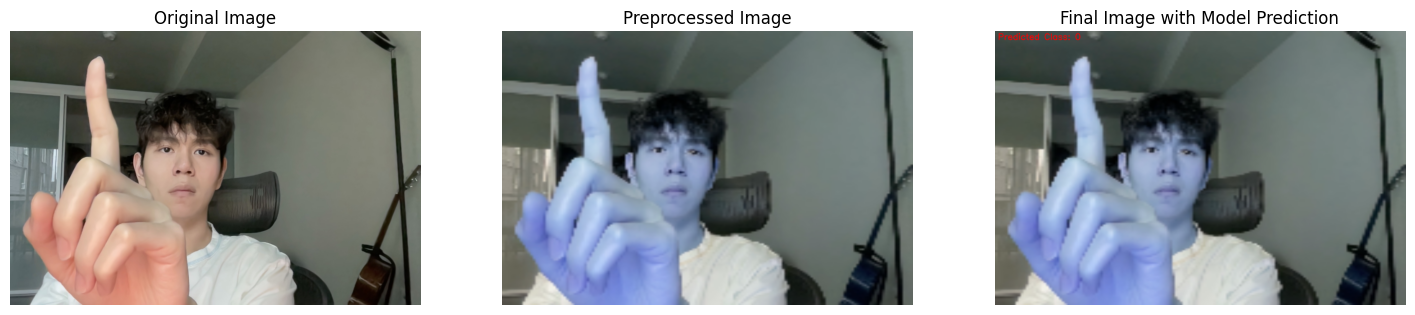

In [14]:
# Function to plot images side by side
def plot_images(original_path, preprocessed_img, model, image_index):
    # Original image
    original_img = cv2.imread(original_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Preprocessed image (ready for the model)
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    preprocessed_display = cv2.resize(preprocessed_img, (original_img.shape[1], original_img.shape[0]))
    plt.imshow(preprocessed_display)
    plt.title('Preprocessed Image')
    plt.axis('off')

    # Make prediction
    prediction = model.predict(np.expand_dims(preprocessed_img, axis=0))
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Final image with prediction (for visualization purposes, we'll just write the predicted class over the preprocessed image)
    final_img = preprocessed_display.copy()
    cv2.putText(final_img, f'Predicted Class: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    plt.subplot(1, 3, 3)
    plt.imshow(final_img)
    plt.title('Final Image with Model Prediction')
    plt.axis('off')

    plt.show()

# Assuming the first image in your dataset is what you want to display
plot_images(imagepaths[0], X[0], model, 0)

# Testing Model

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

12/12 [==============================] - 1s 75ms/step - loss: 0.6627 - accuracy: 0.8972
Test accuracy: 89.72%


In [16]:
# Make predictions on the test set
predictions = model.predict(X_test)
np.argmax(predictions[0]), y_test[0] # If same, got it right

12/12 [==============================] - 1s 73ms/step


(1, 1)

In [17]:
def validate_images(predictions_array, true_label_array, img_array, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(6):  # Displaying 6 images
        prediction = predictions_array[i]
        true_label = true_label_array[i]
        img = img_array[i]
        
        plt.subplot(2, 3, i+1)  # Arranging images in a 2x3 grid
        plt.xticks([])
        plt.yticks([])
        
        # Since images are already in the correct format, directly display them
        plt.imshow(img)  # Removed cmap=plt.cm.binary since images are RGB
        predicted_label = np.argmax(prediction)
        
        # Coloring title based on prediction accuracy
        if predicted_label == true_label:
            color = 'blue'
        else:
            color = 'red'
        
        plt.xlabel(f"Predicted: {class_names[predicted_label]} ({100*np.max(prediction):.2f}%) \n(True: {class_names[true_label]})", color=color)
    plt.tight_layout()
    plt.show()

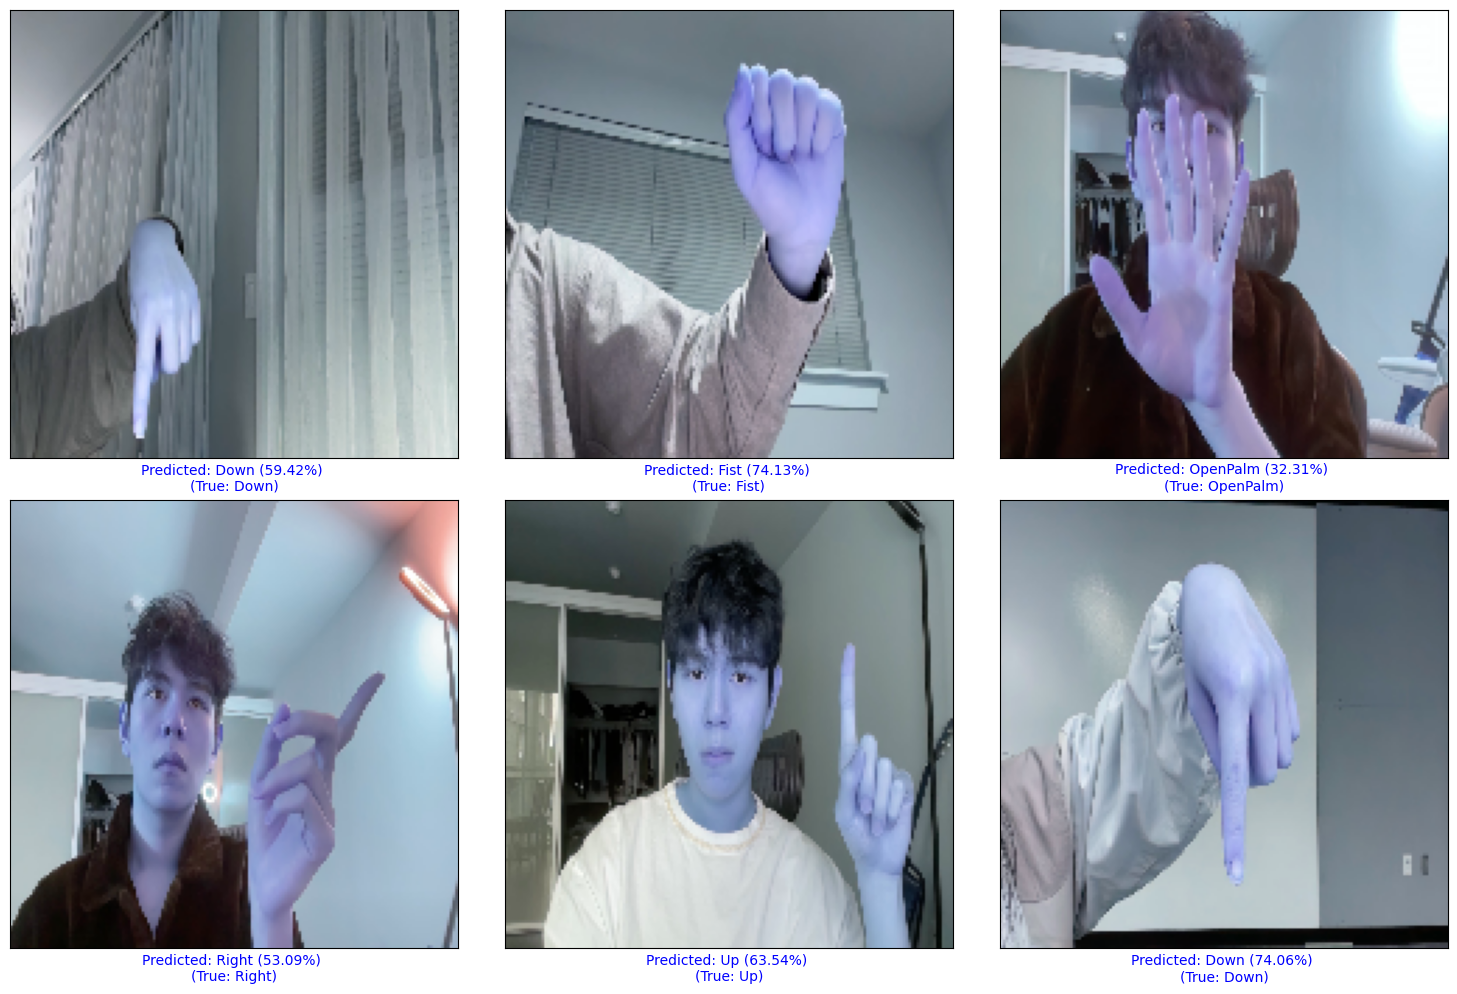

In [18]:
class_names = ["Up", "Down", "Left", "Right", "OpenPalm", "Fist"]
y_pred = np.argmax(predictions, axis=1)
validate_images(predictions, y_test, X_test, class_names)

12/12 [==============================] - 1s 73ms/step


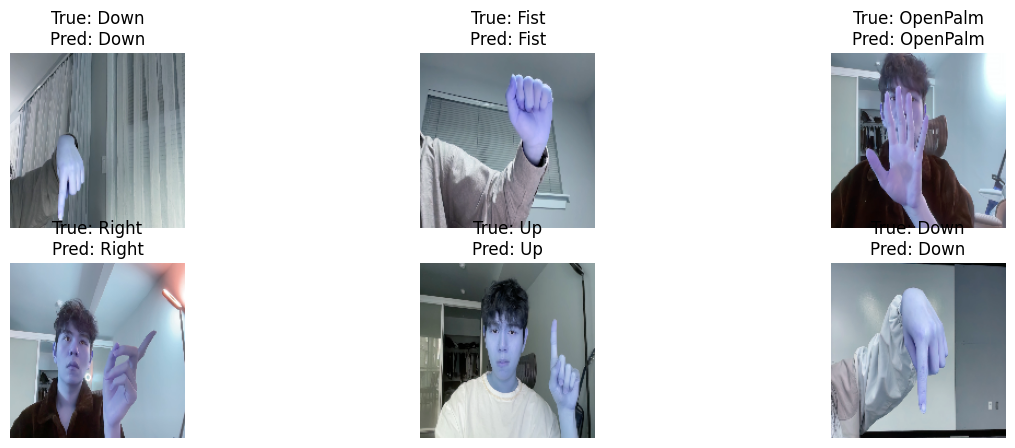

              precision    recall  f1-score   support

          Up       0.93      0.92      0.93        62
        Down       0.95      0.96      0.96        56
        Left       0.80      0.92      0.86        62
       Right       0.90      0.84      0.87        56
    OpenPalm       0.86      1.00      0.93        56
        Fist       0.96      0.76      0.85        68

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



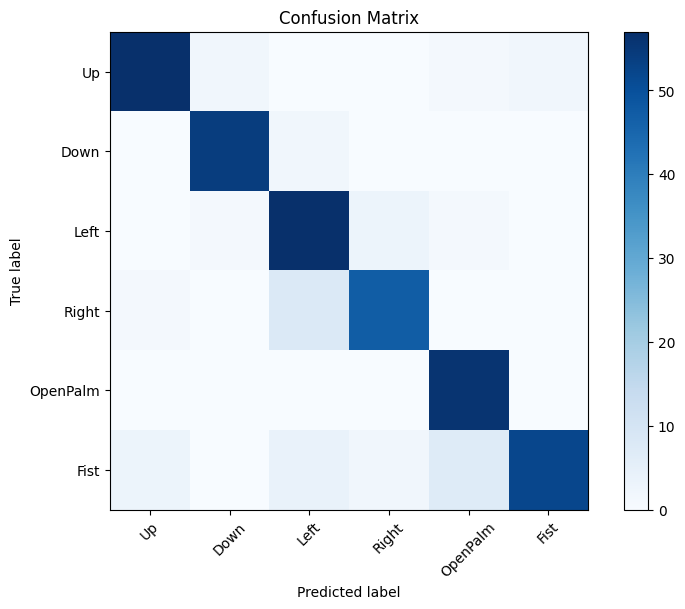

          Up  Down  Left  Right  OpenPalm  Fist
Up        57     2     0      0         1     2
Down       0    54     2      0         0     0
Left       0     1    57      3         1     0
Right      1     0     8     47         0     0
OpenPalm   0     0     0      0        56     0
Fist       3     0     4      2         7    52


In [19]:
# Function to display images with predictions
def display_predictions(images, true_labels, predictions, class_names, num_images=6):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.show()

# Generate predictions for the test set
predictions = np.argmax(model.predict(X_test), axis=1)

# Display a subset of test images with their predicted and true labels
display_predictions(X_test, y_test, predictions, class_names=["Up", "Down", "Left", "Right", "OpenPalm", "Fist"])

# Generate the classification report
print(classification_report(y_test, predictions, target_names=["Up", "Down", "Left", "Right", "OpenPalm", "Fist"]))

# Generate and display a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# If you want to see the confusion matrix as a DataFrame:
import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
print(conf_matrix_df)

# Deploying Model

In [5]:
# Load the gesture recognition model
model = load_model('gesture_recognition_model.h5')

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Initialize the keyboard controller
keyboard = Controller()

# Define class names for your gestures
class_names = ["Up", "Down", "Left", "Right", "OpenPalm", "Fist"]

# Function for preprocessing the captured frame
def preprocess_frame(frame):
    # Convert frame to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Resize the frame to match the model input
    frame_resized = cv2.resize(frame_rgb, (160, 160))
    # Normalize pixel values
    frame_normalized = frame_resized / 255.0
    # Expand dimensions to add batch size
    frame_expanded = np.expand_dims(frame_normalized, axis=0)
    return frame_expanded

# Function to simulate keyboard actions
def simulate_key_press(predicted_class):
    key_mapping = {
        "Up": Key.up,
        "Down": Key.down,
        "Left": Key.left,
        "Right": Key.right,
        "OpenPalm": ('cmd', '='),
        "Fist": ('cmd', '-')
    }
    action = key_mapping.get(predicted_class)

    if isinstance(action, tuple):  # Combined actions like OpenPalm and Fist
        modifier, key = action
        with keyboard.pressed(getattr(Key, modifier)):  # Use getattr to handle the modifier key
            keyboard.press(key)
            keyboard.release(key)
    elif action:  # Single key actions
        keyboard.press(action)
        keyboard.release(action)

# Main loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame for model prediction
    preprocessed_frame = preprocess_frame(frame)

    # Predict the gesture
    predictions = model.predict(preprocessed_frame)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    # Simulate the corresponding keyboard action
    simulate_key_press(predicted_class)

    # Display the frame (optional, for debugging)
    cv2.imshow("Gesture Recognition", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
